<a href="https://colab.research.google.com/github/gani88/CrackDetectionInPainting/blob/main/CrackDetectionPainting_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Unzip File Dataset
import zipfile

local_zip = '/content/PaintingDataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [2]:
import os

base_dir = '/content/Painting Dataset'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/Training'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/Validation'))

Contents of base directory:
['Training', 'Validation']

Contents of train directory:
['Crack', 'NonCrack']

Contents of validation directory:
['Crack', 'NonCrack']


In [3]:
import os

train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory with training crack and noncrack images pictures
train_noncrack_dir = os.path.join(train_dir, 'NonCrack')
train_crack_dir = os.path.join(train_dir, 'Crack')

# Directory with validation crack and noncrack images pictures
validation_noncrack_dir = os.path.join(validation_dir, 'NonCrack')
validation_crack_dir = os.path.join(validation_dir, 'Crack')

In [4]:
train_noncrack_fnames = os.listdir( train_noncrack_dir )
train_crack_fnames = os.listdir( train_crack_dir )

print("Non Crack Painting : ", train_noncrack_fnames[:10])
print("Crack Painting : ", train_crack_fnames[:10])

Non Crack Painting :  ['0096.jpg', '0229.jpg', '0163.jpg', '0246.jpg', '0037.jpg', '0220.jpg', '0159.jpg', '0432.jpg', '0252.jpg', '0230.jpg']
Crack Painting :  ['03fortu1.jpg', '4portr_y.jpg', '6selfpor.jpg', 'grabow2.jpg', 'crucifi1.jpg', '16rolin3.jpg', '3gonzaga.jpg', '07folig2.jpg', 'angel4.jpg', '7sorrows.jpg']


In [5]:
print('total training NonCrack images :', len(os.listdir(      train_noncrack_dir ) ))
print('total training Crack images :', len(os.listdir(      train_crack_dir ) ))

print('total validation NonCrack images :', len(os.listdir( validation_noncrack_dir ) ))
print('total validation Crack images :', len(os.listdir( validation_crack_dir ) ))

total training NonCrack images : 240
total training Crack images : 240
total validation NonCrack images : 60
total validation Crack images : 60


In [6]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt


nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

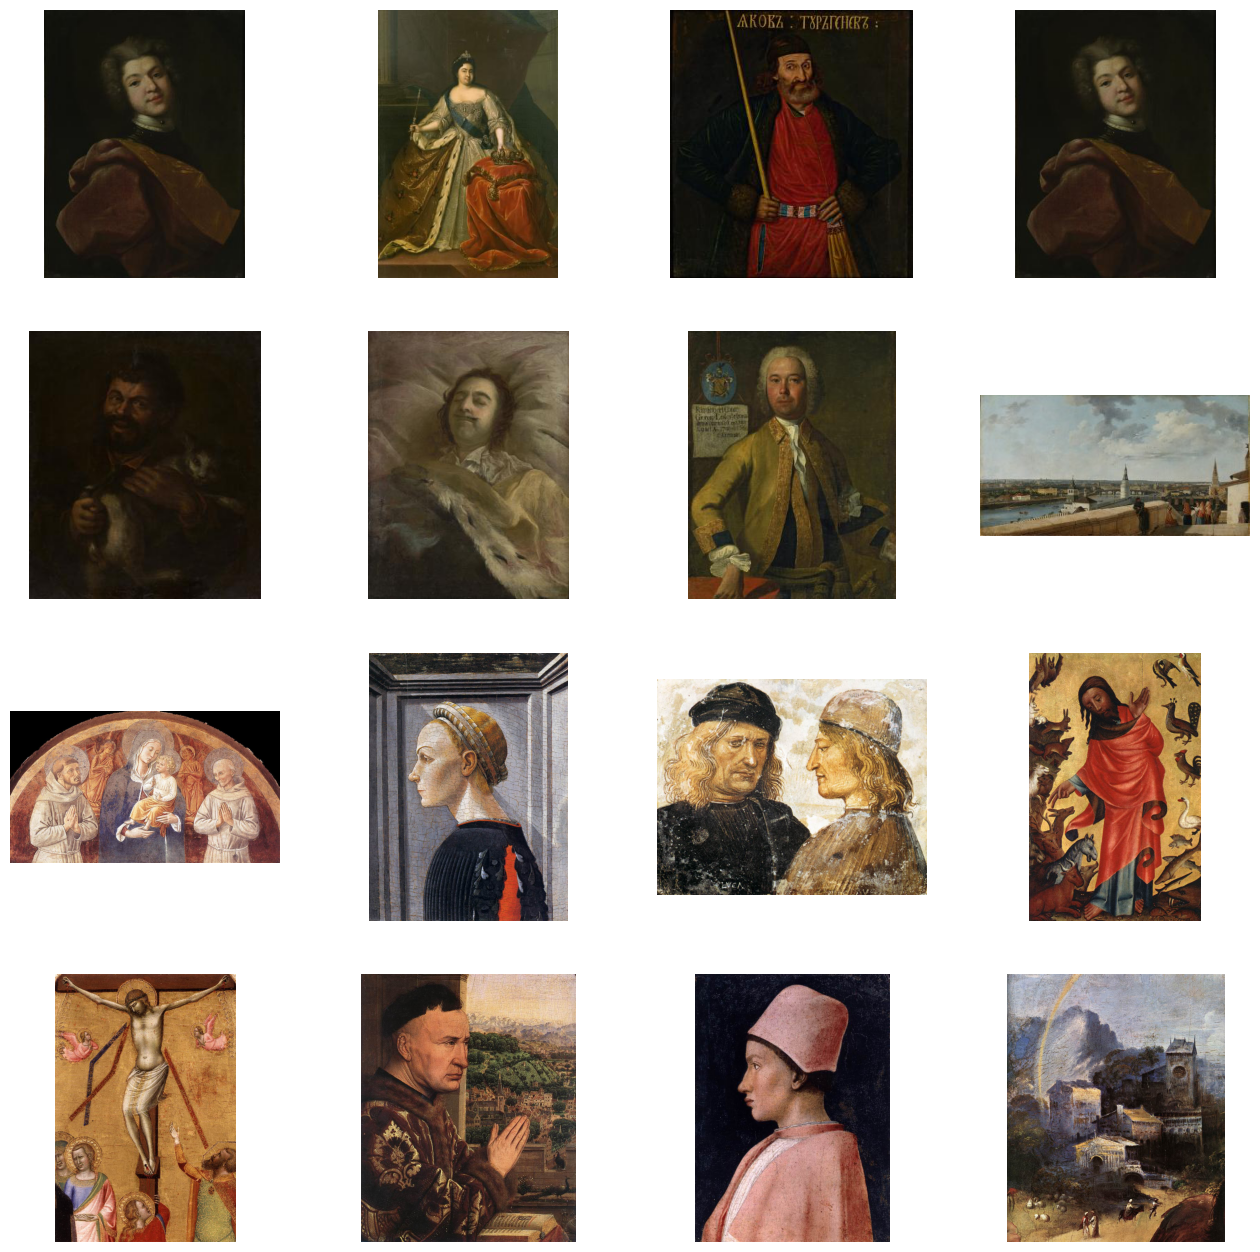

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_noncrack_pix = [os.path.join(train_noncrack_dir, fname) 
                for fname in train_noncrack_fnames[ pic_index-8:pic_index] 
               ]

next_crack_pix = [os.path.join(train_crack_dir, fname) 
                for fname in train_crack_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_noncrack_pix+next_crack_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
# Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale 1/255
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [31]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the custom preprocessing function
def custom_preprocessing(img):
    # Define the kernel size for the top-hat transform
    kernel_size = 10
    # Define the structuring element for the top-hat transform
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    # Perform the top-hat transform to enhance the contrast of the cracks
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    # Define the kernel size for the dilation operation
    kernel_size = 3
    # Define the structuring element for the dilation operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    # Perform the dilation operation to expand the boundaries of the cracks
    dilated = cv2.dilate(tophat, kernel)
    # Return the preprocessed image
    return dilated

# Define the data generators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=custom_preprocessing
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_preprocessing
)

# Load the training and validation data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(250, 250),
    batch_size=20,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(250, 250),
    batch_size=20,
    class_mode='binary'
)


Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [32]:
# Model
import tensorflow as tf

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(250, 250, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('noncrack') and 1 for the other ('crack')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 248, 248, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 124, 124, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 29, 29, 64)      

In [34]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [35]:
history = model.fit(
            train_generator,
            epochs=10,
            validation_data=val_generator,
            verbose=1
            )

Epoch 1/10
24/24 [==============================] - 15s 533ms/step - loss: 0.5912 - accuracy: 0.7646 - val_loss: 0.1748 - val_accuracy: 0.9000
Epoch 2/10
24/24 [==============================] - 13s 537ms/step - loss: 0.1931 - accuracy: 0.9292 - val_loss: 0.0711 - val_accuracy: 0.9833
Epoch 3/10
24/24 [==============================] - 13s 535ms/step - loss: 0.1864 - accuracy: 0.9354 - val_loss: 0.3767 - val_accuracy: 0.8167
Epoch 4/10
24/24 [==============================] - 13s 534ms/step - loss: 0.1386 - accuracy: 0.9396 - val_loss: 0.1283 - val_accuracy: 0.9667
Epoch 5/10
24/24 [==============================] - 13s 528ms/step - loss: 0.1656 - accuracy: 0.9312 - val_loss: 0.2202 - val_accuracy: 0.8750
Epoch 6/10
24/24 [==============================] - 13s 536ms/step - loss: 0.1424 - accuracy: 0.9438 - val_loss: 0.1676 - val_accuracy: 0.9083
Epoch 7/10
24/24 [==============================] - 13s 535ms/step - loss: 0.1768 - accuracy: 0.9354 - val_loss: 0.0962 - val_accuracy: 0.9583

In [37]:
# Prediksi lukisan memiliki retakan atau tidak.
## Pinpoint untuk tahap selanjutnya dalam melakukan patching pada lukisan retak

import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(250, 250))
  
  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0.5:
    print(fn + " is a crack")
  else:
    print(fn + " is a noncrack")

Saving IMG_7912.jpg to IMG_7912 (2).jpg
1/1 [==============================] - 0s 166ms/step
[3.146415e-10]
IMG_7912.jpg is a noncrack


Text(0.5, 1.0, 'Training and validation loss')

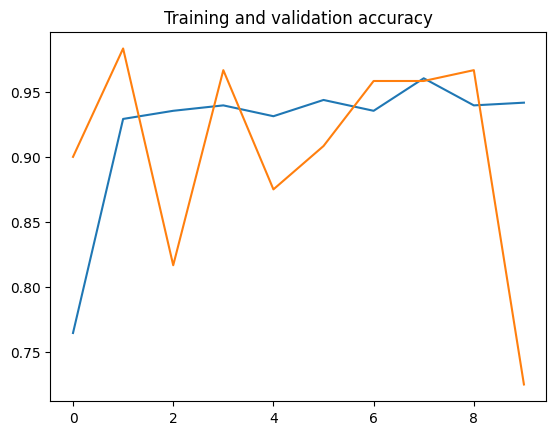

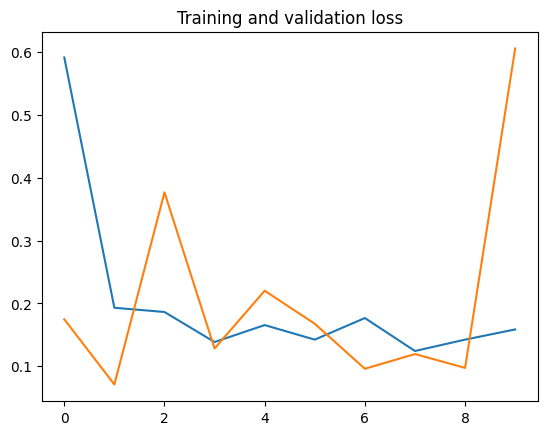

In [38]:

acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) 

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )